# Lab 9 -- 2d fft

## Lab 9 problem

Hand in a version of this notebook that solves [Problem lowpass](#problem_lowpass) below

## 2D histogram of the optical depth $\tau$

Below I calculate the 2-d and averaged 1-d spectra for the optical depth, which gives the penetration
depth of photons through a cloud, and is closely related to cloud thickness

In [1]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
import context
from matplotlib import pyplot as plt
from numlabs.data_read import download
satfile = 'a17.nc'
download('a17.nc',root="https://clouds.eos.ubc.ca/~phil/docs/atsc500/data")

******************************
context imported. Front of path:
/Users/phil/repos/numeric
back of path: /Users/phil/.ipython
******************************

through /Users/phil/repos/numeric/notebooks/lab9/context.py
trying https://clouds.eos.ubc.ca/~phil/docs/atsc500/data/a17.nc
writing to: a17.nc

a17.nc already exists
and is 16777384 bytes
will not overwrite



In [3]:
from netCDF4 import Dataset
with Dataset(satfile) as nc:
    tau=nc.variables['tau'][...]

## Character of the optical depth field

The image below shows one of the marine boundary layer landsat scenes analyzed in 
[Lewis et al., 2004](http://onlinelibrary.wiley.com/doi/10.1029/2003JD003742/full)

It is a 2048 x 2048 pixel image taken by Landsat 7, with the visible reflectivity converted to
cloud optical depth.   The pixels are 25 m x 25 m, so the scene extends for about 50 km x 50 km

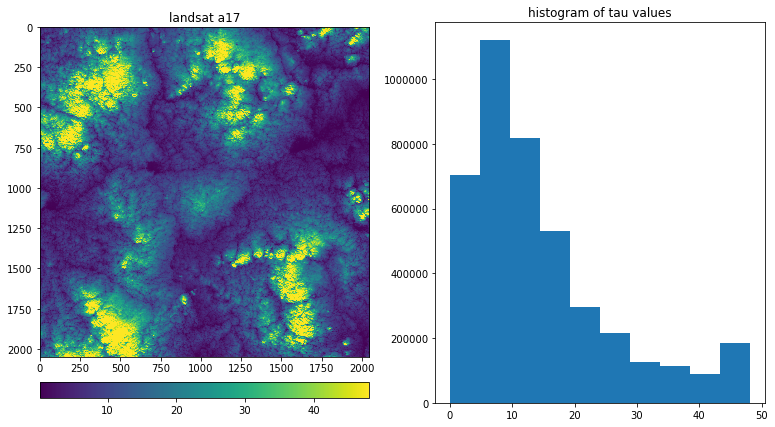

In [4]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.close('all')
fig,ax=plt.subplots(1,2,figsize=(13,7))
ax[0].set_title('landsat a17')
im0=ax[0].imshow(tau)
im1=ax[1].hist(tau.ravel())
ax[1].set_title('histogram of tau values')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im0,orientation='horizontal',cax=cax)

## ubc_fft class

In the next cell I define a class that calculates the 2-d fft for a square image

in the method ```power_spectrum``` we calculate both the 2d fft and the power spectrum
and save them as class attributes.  In the method ```annular_average``` I take the power spectrum,
which is the two-dimensional field  $E(k_x, k_y)$ (in cartesian coordinates) or $E(k,\theta)$ (in polar coordinates).
In the method ```annular_avg``` I take the average

$$
\overline{E}(k) = \int_0^{2\pi} E(k, \theta) d\theta
$$

and plot that average with the method ```graph_spectrum```

In [5]:
from netCDF4 import Dataset
import numpy as np
import math
from numpy import fft
from matplotlib import pyplot as plt


class ubc_fft:

    def __init__(self, filename, var, scale):
        """
           Input filename, var=variable name, 
           scale= the size of the pixel in km

           Constructer opens the netcdf file, reads the data and
           saves the twodimensional fft
        """
        with Dataset(filename,'r') as fin:
            data = fin.variables[var][...]
        data = data - data.mean()
        if data.shape[0] != data.shape[1]:
            raise ValueError('expecting square matrix')
        self.xdim = data.shape[0]     # size of each row of the array
        self.midpoint = int(math.floor(self.xdim/2))
        root,suffix = filename.split('.')
        self.filename = root
        self.var = var
        self.scale = float(scale)
        self.data = data
        self.fft_data = fft.fft2(self.data)
    
    def power_spectrum(self):
        """
           calculate the power spectrum for the 2-dimensional field
        """
        #
        # fft_shift moves the zero frequency point to the  middle
        # of the array  
        #
        fft_shift = fft.fftshift(self.fft_data)
        spectral_dens = fft_shift*np.conjugate(fft_shift)/(self.xdim*self.xdim)
        spectral_dens = spectral_dens.real
        #
        # dimensional wavenumbers for 2dim spectrum  (need only the kx
        # dimensional since image is square
        #
        k_vals = np.arange(0,(self.midpoint))+1
        k_vals = (k_vals-self.midpoint)/(self.xdim*self.scale)
        self.spectral_dens=spectral_dens
        self.k_vals=k_vals

    def annular_avg(self,avg_binwidth):
        """ 
         integrate the 2-d power spectrum around a series of rings 
         of radius kradial and average into a set of 1-dimensional
         radial bins
        """
        #
        #  define the k axis which is the radius in the 2-d polar version of E
        #
        numbins = int(round((math.sqrt(2)*self.xdim/avg_binwidth),0)+1)

        avg_spec = np.zeros(numbins,np.float64)
        bin_count = np.zeros(numbins,np.float64)

        print("\t- INTEGRATING... ")
        for i in range(self.xdim):
            if (i%100) == 0:
                print("\t\trow: {} completed".format(i))
            for j in range(self.xdim):
                kradial = math.sqrt(((i+1)-self.xdim/2)**2+((j+1)-self.xdim/2)**2)
                bin_num = int(math.floor(kradial/avg_binwidth))
                avg_spec[bin_num]=avg_spec[bin_num]+ kradial*self.spectral_dens[i,j]
                bin_count[bin_num]+=1

        for i in range(numbins):
            if bin_count[i]>0:
                avg_spec[i]=avg_spec[i]*avg_binwidth/bin_count[i]/(4*(math.pi**2))
        self.avg_spec=avg_spec
        #
        # dimensional wavenumbers for 1-d average spectrum
        #
        self.k_bins=np.arange(numbins)+1
        self.k_bins = self.k_bins[0:self.midpoint]
        self.avg_spec = self.avg_spec[0:self.midpoint]

        
    
    def graph_spectrum(self, kol_slope=-5./3., kol_offset=1., \
                      title=None):
        """
           graph the annular average and compare it to Kolmogorov -5/3
        """
        avg_spec=self.avg_spec
        delta_k = 1./self.scale                # 1./km (1/0.025 for landsat 25 meter pixels)
        nyquist = delta_k * 0.5
        knum = self.k_bins * (nyquist/float(len(self.k_bins)))# k = w/(25m)
        #
        # draw the -5/3 line through a give spot
        #
        kol = kol_offset*(knum**kol_slope)
        fig,ax=plt.subplots(1,1,figsize=(8,8))
        ax.loglog(knum,avg_spec,'r-',label='power')
        ax.loglog(knum,kol,'k-',label="$k^{-5/3}$")
        ax.set(title=title,xlabel='k (1/km)',ylabel='$E_k$')
        ax.legend()
        self.plotax=ax

In [6]:
plt.close('all')
plt.style.use('ggplot')
output = ubc_fft('a17.nc','tau',0.025)
output.power_spectrum()

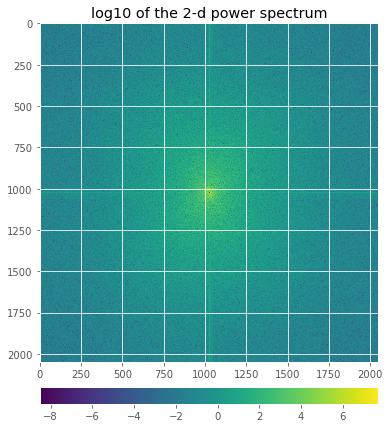

In [7]:
fig,ax=plt.subplots(1,1,figsize=(7,7))
ax.set_title('landsat a17')
im0=ax.imshow(np.log10(output.spectral_dens))
ax.set_title('log10 of the 2-d power spectrum')
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im0,orientation='horizontal',cax=cax)

In [8]:
avg_binwidth=5  #make the kradial bins 5 pixels wide
output.annular_avg(avg_binwidth)

	- INTEGRATING... 
		row: 0 completed
		row: 100 completed
		row: 200 completed
		row: 300 completed
		row: 400 completed
		row: 500 completed
		row: 600 completed
		row: 700 completed
		row: 800 completed
		row: 900 completed
		row: 1000 completed
		row: 1100 completed
		row: 1200 completed
		row: 1300 completed
		row: 1400 completed
		row: 1500 completed
		row: 1600 completed
		row: 1700 completed
		row: 1800 completed
		row: 1900 completed
		row: 2000 completed


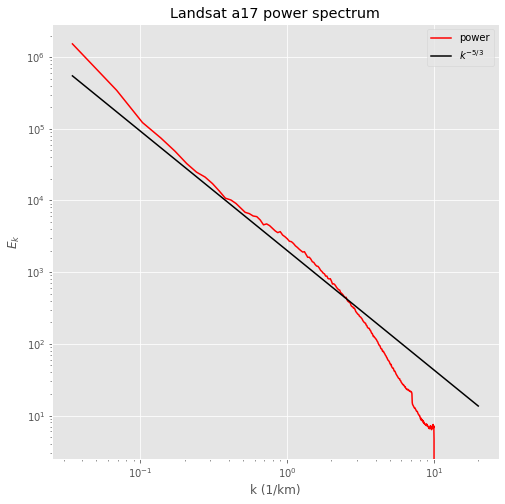

In [9]:
output.graph_spectrum(kol_offset=2000.,title='Landsat {} power spectrum'.format(output.filename))

<div id="problem_lowpass"></div>

## Problem -- lowpass filtering of a 2-d image

For the image above, 
we know that the 25 meter pixels correspond to k=1/0.025 = 40 $km^{-1}$.  That means that the Nyquist
wavenumber is k=20 $km^{-1}$.  Using that information, design a filter that removes all wavenumbers
higher than 1 $km^{-1}$.   

1) Use that filter to zero those values in the fft, then inverse transform and
plot the low-pass filtered image.

2) Take the 1-d fft of the image and repeat the plot of the power spectrum to show that there is no power in wavenumbers higher than 1 $km^{-1}$.

(Hint -- I used the fftshift function to put the low wavenumber cells in the center of the fft, which made it simpler to zero the outer cells.  I then used ifftshift to reverse shift before inverse transforming to get the filtered
image.)

